In [58]:
import numpy as np
import torch

from scipy.io import loadmat
from scipy.signal import stft

from scipy import ndimage, misc

def Normalize(arr : np.array) -> np.array:
    return (arr-np.min(arr))/(np.max(arr)-np.min(arr))

def ScaleToSquare(arr: np.ndarray, size: int) -> np.ndarray:
    return ndimage.zoom(arr, (size/arr.shape[0],size/arr.shape[1]))

class BearingDataset(torch.utils.data.Dataset):
    def __init__(self, transform = None, target_transform = None, img_size = 64, segment_size = 1024, step = 128, Nw = 256, No = 250, fs = 12000.):
        self.img_size = img_size
        self.segment_size = segment_size
        self.step = step
        self.Nw = Nw  # window width from 4.3 section
        self.No = No  # window overlap from 4.3 section
        self.fs = fs  # 12KHz

        # Let use only A, B, C datasets
        self.labels = ['Normal', 'BA007','BA014','BA021','IR007','IR014','IR021','OR007','OR014','OR021']
        self.filenames = ['../datasets/A/None/97.mat', '../datasets/A/BA/0.007/118.mat', '../datasets/A/BA/0.014/185.mat',
                         '../datasets/A/BA/0.021/222.mat', '../datasets/C/IR/0.007/105.mat', '../datasets/C/IR/0.014/169.mat', 
                        '../datasets/C/IR/0.021/209.mat','../datasets/C/OR/0.007/130.mat', '../datasets/C/OR/0.014/197.mat', 
                        '../datasets/C/OR/0.021/234.mat']
        assert(len(self.labels) == len(self.filenames))
        self.img_labels = []
        for idx, filename in enumerate(self.filenames):
            signal = loadmat(filename)
            drive_end_key = [k for k in signal.keys() if 'DE_time' in k]
            if not len(drive_end_key):
                continue
            de_signal = signal[drive_end_key[0]].ravel()
            for i in range(0, (len(de_signal) -  self.segment_size), self.step):
                pack_data = de_signal[i : i + self.segment_size]
                freq, time, zmag = stft(pack_data, fs, window='hann', nperseg=self.Nw, noverlap=self.No)
                scaled_zmag = ScaleToSquare(np.abs(zmag), self.img_size)
                normalized_zmag = Normalize(scaled_zmag)
                self.img_labels.append((normalized_zmag,idx))
            
    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        return self.img_labels[idx]
    
    def getlabel(self, idx):
        return self.labels[idx]
    
    def getimgs(self, labelidx):
        return [image for _, (image,label) in enumerate(self.img_labels) if label == labelidx]


In [61]:
bearing_dataset = BearingDataset()
print('Loaded bearing dataset: ', len(bearing_dataset))


Loaded bearing dataset:  10408


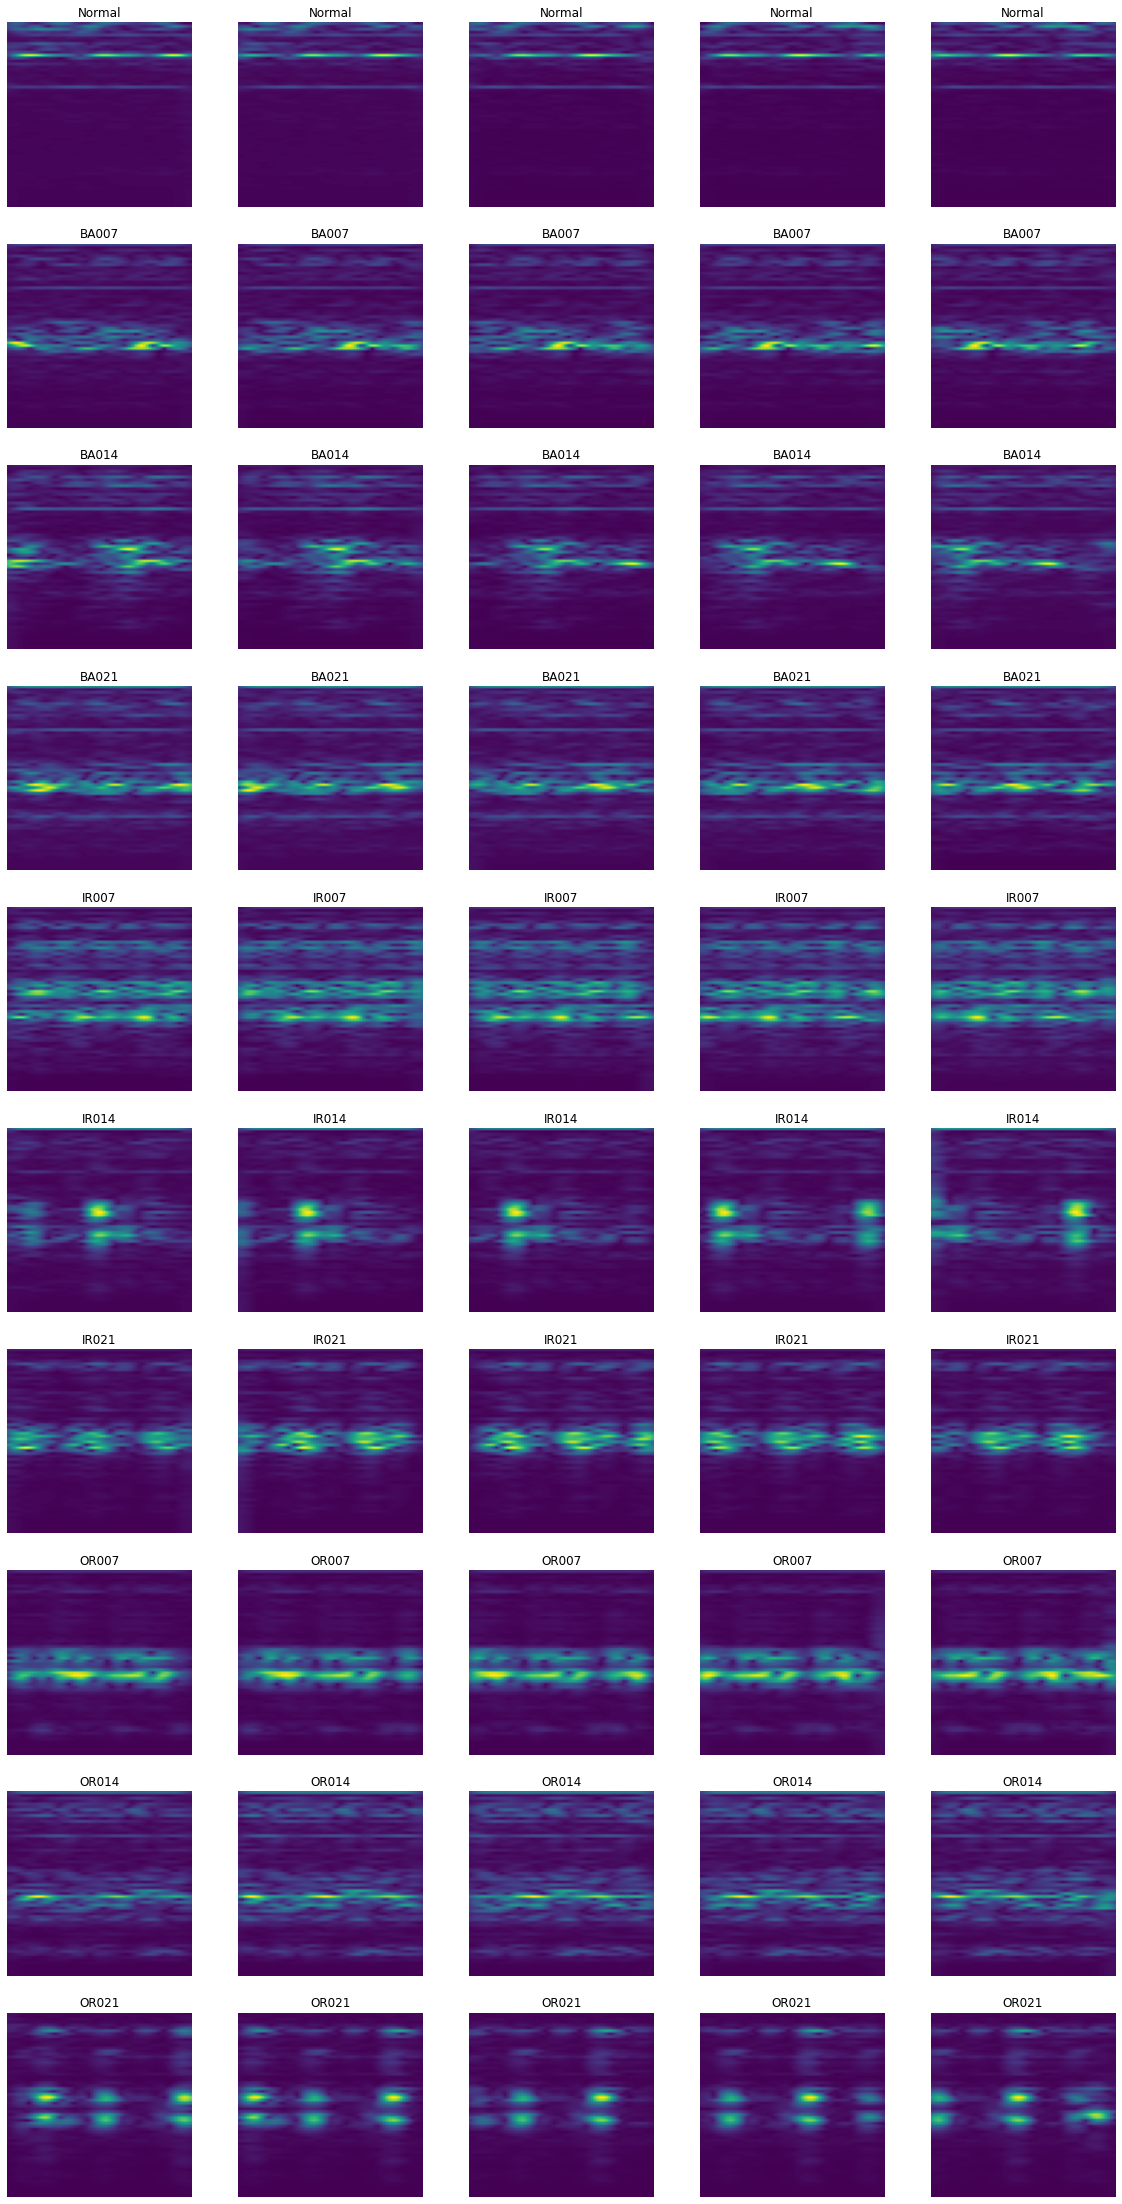

In [63]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(20, 40))
index = 0
for lbl_idx in range(10):
    images = bearing_dataset.getimgs(lbl_idx)[:5]
    for img in images:
        plt.subplot(10, 5, index + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(bearing_dataset.getlabel(lbl_idx))
        index = index + 1
        if index == 50: break
plt.show()